In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from enum import Enum
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
EXPORTS_DIR = '../data/exports'
MATRIX_DIR = '../data/exports/adjacency_matrix'
SHAPEFILE_DIR = '../data/shapefiles/zipcodes'
CENTROIDS_DIR = '../data/exports'
LABELS_DIR = '../data/exports'
STATIONS_DIR = '../data/exports'
CLUSTER = True
K = 25
NODE_TYPE = 'station_id'

if CLUSTER:
    MATRIX_DIR = f'{MATRIX_DIR}/k{K}'
    NODE_TYPE = 'label'


class AnalysisConfig:
    def __init__(self, shapefile_path='', stations_path='', city_suffix=''):
        self.shapefile_path = shapefile_path
        self.stations_path = stations_path
        self.centroids_path = (
            f'{CENTROIDS_DIR}/centroids_k25_{city_suffix}.csv')
        self.labels_path = (
            f'{LABELS_DIR}/cluster_labels_k25_{city_suffix}.csv')
        self.displacement_matrix_path = (
            f'{MATRIX_DIR}/displacement_{city_suffix}.csv')
        self.elevation_matrix_path = (
            f'{MATRIX_DIR}/elevation_{city_suffix}.csv')
        self.trip_count_classic_matrix_path = (
            f'{MATRIX_DIR}/trip_count_classic_{city_suffix}.csv')
        self.trip_count_electric_matrix_path = (
            f'{MATRIX_DIR}/trip_count_electric_{city_suffix}.csv')
        self.trip_count_matrix_path = (
            f'{MATRIX_DIR}/trip_count_{city_suffix}.csv')
        self.city_suffix = city_suffix

    def get_export_path(self, filename):
        return f'{EXPORTS_DIR}/{filename}_{self.city_suffix}.csv'
    
    def get_nodes_df(self):
        if CLUSTER:
            return pd.read_csv(self.centroids_path).reset_index().rename(columns={
                'index': 'label',
            })
        return pd.read_csv(self.stations_path)


def get_trip_matrix(config, path=None):
    if not path:
        path = config.trip_count_matrix_path
    trip_matrix = pd.read_csv(path, index_col=0)
    trip_matrix.columns = trip_matrix.columns.astype('str')
    trip_matrix.index = trip_matrix.index.astype('str')
    return trip_matrix

In [3]:
config_sf = AnalysisConfig(
    city_suffix = 'sf',
    shapefile_path = f'{SHAPEFILE_DIR}/san_francisco.shp',
    stations_path = f'{STATIONS_DIR}/SF_ele_single station.csv',
)

config_dc = AnalysisConfig(
    city_suffix = 'dc',
    shapefile_path = f'{SHAPEFILE_DIR}/washington_dc.shp',
    stations_path = f'{STATIONS_DIR}/DC_ele_single station.csv',
)

In [4]:
config = config_sf

In [5]:
def load_gdfs(config):
    zips_gdf = gpd.read_file(config.shapefile_path)
    nodes_df = config.get_nodes_df()
    nodes_gdf = gpd.GeoDataFrame(
        nodes_df,
        geometry=gpd.points_from_xy(nodes_df['lng'],
                                    nodes_df['lat'])).set_crs('EPSG:4326')
    nodes_gdf[NODE_TYPE] = nodes_gdf[NODE_TYPE].astype('str')
    return (zips_gdf, nodes_gdf)

In [6]:
zips_gdf, nodes_gdf, = load_gdfs(config)

In [7]:
def normalize_matrix(matrix, max=max, min=0):
    return matrix.sub(min).div(max - min)

In [8]:
labels_df = pd.read_csv(config.labels_path, index_col=0)
display(labels_df)

,label
station_id,
SF-M26,22
SF-M25,22
SF-M26-2,1
SF-L27,1
SF-K26,1
...,...
SF-Z16,7
SF-Y14,9
SF-X14,9


## Clustered Network Analysis

In [9]:
def get_lat_lng(df, node_id):
    return df[df[NODE_TYPE] == node_id][[
        'lat', 'lng'
    ]].iloc[0][:]

def get_lat_lng_edges(matrix, nodes_gdf=nodes_gdf):
    node_ids = list(matrix.columns)
    
    def has_node(id):
        return len(nodes_gdf[nodes_gdf[NODE_TYPE] == id]) > 0
    
    edges = pd.DataFrame([], columns=['lat1', 'lng1', 'lat2', 'lng2', 'value'])
    for id1 in node_ids:
        if not has_node(id1):
            continue
            
        lat1, lng1 = get_lat_lng(nodes_gdf, id1)
        
        for id2 in node_ids:
            if id1 == id2 or not has_node(id2):
                continue
                
            lat2, lng2 = get_lat_lng(nodes_gdf, id2)

            edges = edges.append({
                'lat1': lat1,
                'lng1': lng1,
                'lat2': lat2,
                'lng2': lng2,
                'id1': id1,
                'id2': id2,
                'value': matrix[id1][id2],
            }, ignore_index=True)
            
    return edges

In [10]:
def get_sorted_edges(trip_matrix_norm, normalize=True):
    edges = get_lat_lng_edges(trip_matrix_norm)
    sorted_edges = edges[edges['value'] > 0].sort_values(by='value')
    if normalize:
        sorted_edges['value'] = sorted_edges['value'] / sorted_edges['value'].max()
    return sorted_edges

In [11]:
trip_matrix_all = get_trip_matrix(config, config.trip_count_matrix_path)
trip_max = trip_matrix_all.max().max()
trip_matrix_all = normalize_matrix(trip_matrix_all, max=trip_max)
edges_all = get_sorted_edges(trip_matrix_all)

trip_matrix_classic = get_trip_matrix(config, config.trip_count_classic_matrix_path)
trip_matrix_classic = normalize_matrix(trip_matrix_classic, max=trip_max)
edges_classic = get_sorted_edges(trip_matrix_classic)

trip_matrix_electric = get_trip_matrix(config, config.trip_count_electric_matrix_path)
trip_matrix_electric = normalize_matrix(trip_matrix_electric, max=trip_max)
edges_electric = get_sorted_edges(trip_matrix_electric)

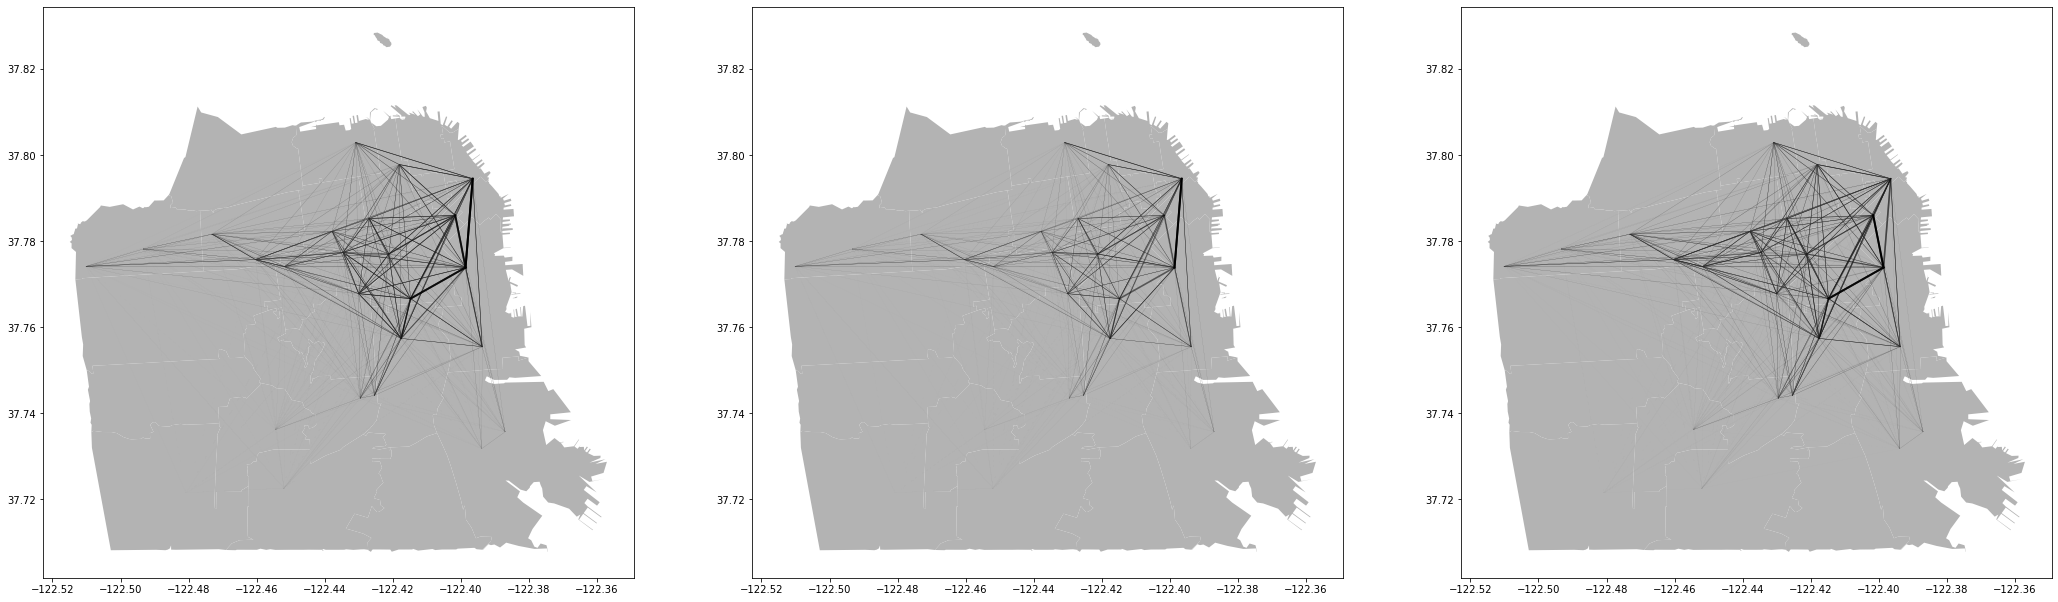

In [12]:
CRS_PLOT = 'EPSG:4326'

def plot_map(fig, ax, zips_gdf):
    zips_gdf.to_crs({'init': CRS_PLOT}).plot(ax=ax, color=str(0.7), zorder=0)
    
def plot_network(fig, ax, edges, title=''):
    for i, edge in edges.iterrows():
        lat1, lng1, lat2, lng2 = edge[['lat1', 'lng1', 'lat2', 'lng2']]
        # 0.0 = black, 1.0 = white, flip and scale to [0.0, 0.5].
        color = (1 - edge['value']) * 0.25
        alpha = max(edge['value'] * 3, 1)
        linewidth = edge['value'] * 2
        ax.plot([lng1, lng2], [lat1, lat2],
                 'k-',
                 linewidth=linewidth,
                 color=str(color),
                 alpha=alpha,
                 zorder=1)

    ax.set_title(title)

fig, ax = plt.subplots(1, 3, figsize=(36, 12))
edges_list = [edges_all, edges_classic, edges_electric]

for i in range(0, 3):
    plot_map(fig, ax[i], zips_gdf)
    plot_network(fig, ax[i], edges_list[i])

plt.show()

In [13]:
def get_flow_df(matrix_path):
    matrix = pd.read_csv(matrix_path).set_index(NODE_TYPE)
    matrix.columns = matrix.columns.astype('str')
    matrix.index = matrix.index.astype('str')
    in_counts = matrix.sum(numeric_only=True)
    out_counts = matrix.sum(axis=1)
    matrix['in'] = in_counts
    matrix['out'] = out_counts
    matrix['diff'] = in_counts - out_counts
    return matrix[['in', 'out', 'diff']]

def get_normalized_column(df, column):
    column_min = df[column].min()
    return (df[column] - column_min) / (df[column].max() - column_min)

def normalize_flow_df(df):
    normalized_df = df.copy()
    normalized_df['in'] = get_normalized_column(df, 'in')
    normalized_df['out'] = get_normalized_column(df, 'out')
    normalized_df['diff'] = get_normalized_column(df, 'diff')
    return normalized_df

trip_flow_df = get_flow_df(config.trip_count_matrix_path)

In [14]:
zips_gdf, nodes_gdf = load_gdfs(config)
nodes_flow_gdf = pd.merge(nodes_gdf, trip_flow_df, on=NODE_TYPE)
nodes_gdf['count'] = (nodes_gdf['count'] - nodes_gdf['count'].min()) / (nodes_gdf['count'].max() - nodes_gdf['count'].min())

In [15]:
def plot_nodes(fig, ax, nodes_gdf, column, title, top_n=None, bottom_n=None, outline=False, colormap='coolwarm_r'):
    all_gdf = nodes_gdf.to_crs({'init': CRS_PLOT}).copy()
    
    gdfs = []
    if top_n or bottom_n:
        all_gdf = all_gdf.sort_values([column], ascending=False)
        if top_n:
            gdfs.append(all_gdf.iloc[0:top_n, :])
        if bottom_n:
            gdfs.append(all_gdf.iloc[-bottom_n:, :])
    else:
        gdfs.append(all_gdf)
        
    gdf = pd.concat(gdfs)
    markersize = nodes_gdf['count'] * 150 + 50
    if outline == False:
        gdf.plot(ax=ax,
                 column=column,
                 norm=matplotlib.colors.Normalize(),
                 cmap=colormap,
                 edgecolors='black',
                 markersize=markersize,
                 zorder=2)
    else:
        gdf.plot(ax=ax,
                 column=column,
                 norm=matplotlib.colors.Normalize(),
                 cmap='coolwarm',
                 edgecolors='black',
                 markersize=markersize * 2,
                 zorder=2)
    ax.set_title(title)
    
    return fig, ax

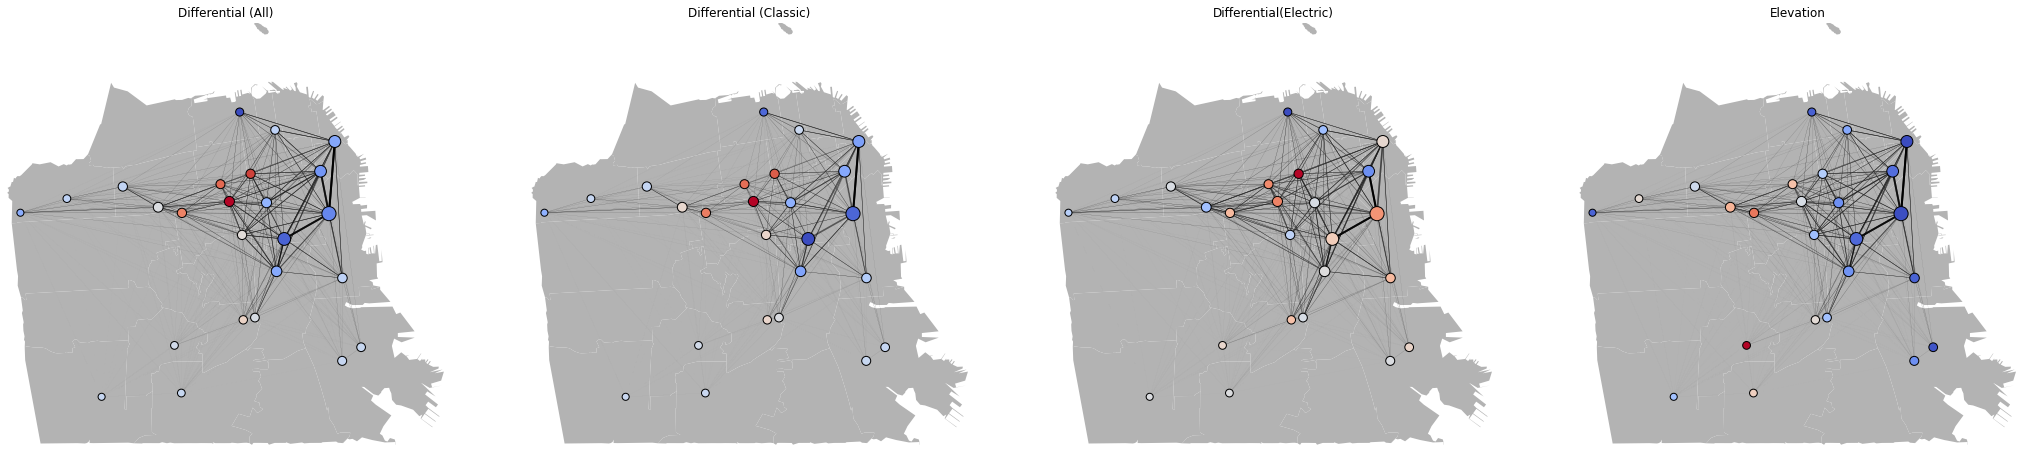

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(36, 20))
edges_list = [edges_all, edges_classic, edges_electric]
titles = ['Differential (All)', 'Differential (Classic)', 'Differential(Electric)']

trip_flow_dfs = [
    get_flow_df(config.trip_count_matrix_path),
    get_flow_df(config.trip_count_classic_matrix_path),
    get_flow_df(config.trip_count_electric_matrix_path),
]

zips_gdf, nodes_gdf = load_gdfs(config)
nodes_gdf['count'] = (nodes_gdf['count'] - nodes_gdf['count'].min()) / (nodes_gdf['count'].max() - nodes_gdf['count'].min())
nodes_flow_gdfs = [
    pd.merge(nodes_gdf, df, on=NODE_TYPE) for df in trip_flow_dfs]


for i in range(0, 3):
    plot_map(fig, ax[i], zips_gdf)
    plot_network(fig, ax[i], edges_list[i])
    plot_nodes(fig, ax[i], nodes_flow_gdfs[i], 'diff', title=titles[i])
    
plot_map(fig, ax[3], zips_gdf)
plot_network(fig, ax[3], edges_list[0])
plot_nodes(fig, ax[3], nodes_flow_gdfs[0], 'elevation', title='Elevation', colormap='coolwarm')
    
for i in range(0, 4):
    ax[i].axis('off')
    ax[i].margins(0)
    ax[i].apply_aspect()

## Hypothesis Testing

In [17]:
def get_trips_from_matrix(matrix):
    node_ids = list(matrix.columns)
    data = []
    for id1 in node_ids:
        for id2 in node_ids:
            if id1 != id2:
                data.append({
                    'id1': id1,
                    'id2': id2,
                    'value': matrix[id1][id2],
                })
    return pd.DataFrame(data)

In [18]:
trip_matrix_classic = get_trip_matrix(config,
                                      config.trip_count_classic_matrix_path)
trip_matrix_classic = normalize_matrix(trip_matrix_classic, max=trip_max)
edges_classic = get_sorted_edges(trip_matrix_classic, normalize=False)

trip_matrix_electric = get_trip_matrix(config,
                                       config.trip_count_electric_matrix_path)
trip_matrix_electric = normalize_matrix(trip_matrix_electric, max=trip_max)
edges_electric = get_sorted_edges(trip_matrix_electric, normalize=False)

In [19]:
def get_merged_edges(edges_classic, edges_electric, matrix_path, variable):
    matrix = get_trip_matrix(config, matrix_path)
    matrix = normalize_matrix(matrix,
                              max=matrix.max().max(),
                              min=matrix.min().min())
    elevations_df = get_trips_from_matrix(matrix)

    edges_classic = pd.merge(edges_classic, elevations_df,
                             on=['id1', 'id2']).rename(columns={
                                 'value_x': 'value',
                                 'value_y': variable,
                             }).sort_values([variable])

    edges_electric = pd.merge(edges_electric, elevations_df,
                              on=['id1', 'id2']).rename(columns={
                                  'value_x': 'value',
                                  'value_y': variable,
                              }).sort_values([variable])

    return (edges_classic, edges_electric)

In [20]:
def plot_hist(fig, ax, df, x, y, color):
    df = df[[x, y]].sort_values(x)
    ax.hist(df[x], bins=100, color=color)
    ax.set_xlabel(x)
    ax.set_ylabel('trips')

In [21]:
def plot_and_test(variable, matrix_path):
    merged_edges_classic, merged_edges_electric = get_merged_edges(
        edges_classic, edges_electric, matrix_path, variable)

    fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
    plot_hist(fig, ax[0], merged_edges_classic, variable, 'value', 'C0')
    plot_hist(fig, ax[1], merged_edges_electric, variable, 'value', 'C1')
    plt.show()

    print(variable)
    display(
        stats.ttest_ind(merged_edges_classic['value'],
                        merged_edges_electric['value']))
    display(
        stats.ks_2samp(merged_edges_classic['value'],
                       merged_edges_electric['value']))

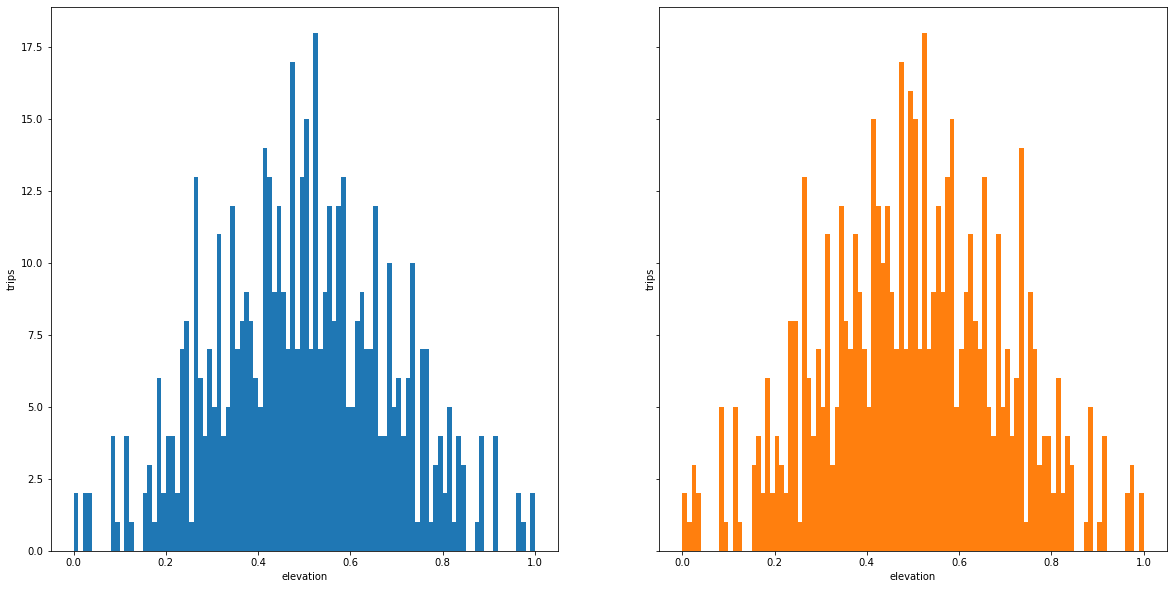

elevation


Ttest_indResult(statistic=-2.792375157966626, pvalue=0.005324184365072519)

KstestResult(statistic=0.15012375817990709, pvalue=8.22413422374435e-06)

In [22]:
plot_and_test('elevation', config.elevation_matrix_path)

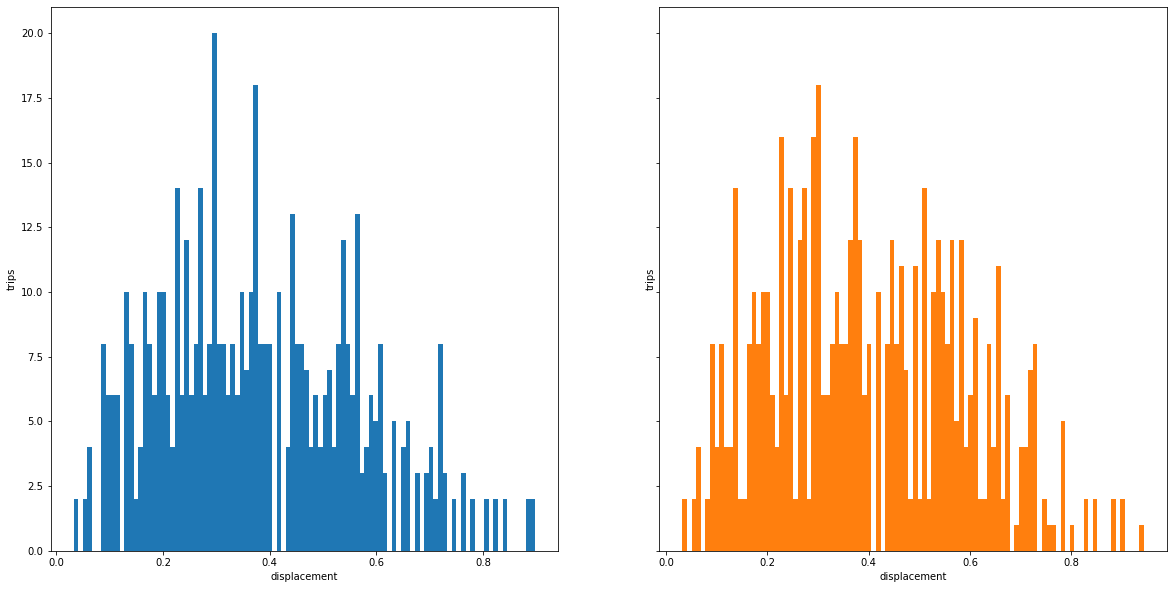

displacement


Ttest_indResult(statistic=-2.7923751579666267, pvalue=0.005324184365072503)

KstestResult(statistic=0.15012375817990709, pvalue=8.22413422374435e-06)

In [23]:
plot_and_test('displacement', config.displacement_matrix_path)